In [220]:
import numpy as np
import matplotlib.pyplot as plt
import polars as pl
from typing import Tuple

# Data Exploration

## Data Visualization

In [ ]:

class SignalProcessor:
    def __init__(self, signal_path: str, info_path: str, chunks: int = 1024, max_peaks: int = 3):
        """
        Initialize SignalProcessor
        """
        self.signal_path = signal_path
        self.info_path = info_path
        self.chunks = chunks
        self.max_peaks = max_peaks

        self.signal_data = self._load_signal_data()
        self.info_data = self._load_info_data()

        # Generate augmented data (original + flipped)
        self.aumented_signal_data, self.aumented_info_data = self._augment_with_flipped_data()

    # ------------------------- LOADING -------------------------
    def _load_signal_data(self) -> np.ndarray: 
        """Load raw signal data and reshape into chunks."""
        with open(self.signal_path, 'rb') as signal_file:
            signal_data = np.fromfile(signal_file, dtype=np.uint8)
            signal_data = signal_data.reshape(-1, self.chunks)
        return signal_data
    
    def _load_info_data(self) -> np.ndarray:
        """Load raw info data."""
        with open(self.info_path, 'rb') as info_file:
            info_data = np.fromfile(info_file, dtype=np.float32)
        return info_data

    # ------------------------- INFO PARSING -------------------------
    def parse_info_array(self, info_array: np.ndarray) -> pl.DataFrame:
        parsed = []
        i = 0
        signal_id = 0

        while i < len(info_array):
            length = int(info_array[i])
            n_peaks = int(info_array[i + 1])
            i += 2

            # Init a base dict
            entry = {
                "signal_id": signal_id,
                "length": length,
                "n_peaks": n_peaks,
                "pos_1": None, "height_1": None, "width_1": None,
                "pos_2": None, "height_2": None, "width_2": None,
                "pos_3": None, "height_3": None, "width_3": None,
            }

            if n_peaks == 0:
                parsed.append(entry)
                i += 9 # skip directly to the next signal
            elif n_peaks > 0:
                # Populate at maximum of 3 peaks
                for p in range(min(n_peaks, 3)):
                    pos = float(info_array[i])
                    height = float(info_array[i + 1])
                    width = float(info_array[i + 2])
                    entry[f"pos_{p+1}"] = pos
                    entry[f"height_{p+1}"] = height
                    entry[f"width_{p+1}"] = width
                i += n_peaks * 3
                if n_peaks == 1:
                    i += 6
                elif n_peaks == 2:
                    i += 3
                elif n_peaks == 3:
                    pass

            parsed.append(entry)
            signal_id += 1

        df = pl.DataFrame(parsed)
        return df

    def parse_info(self) -> pl.DataFrame:
        """Parse original info data."""
        return self.parse_info_array(self.info_data)

    def parse_aumented_info(self) -> pl.DataFrame:
        """Parse augmented info data."""
        return self.parse_info_array(self.aumented_info_data)

    # ------------------------- VISUALIZATION -------------------------
    def visualize_info(self, augmented: bool = False) -> None:
        """Show parsed info as a Polars DataFrame."""
        df = self.aumented_info_data if augmented else self.parse_info()
        pl.Config.set_tbl_rows(200)
        pl.Config.set_tbl_cols(12)
        print(df)

    # ------------------------- PLOTTING -------------------------
    def plot_signals(self, num_signals=50, shuffle=True, seed=42, augmented=False):
        """
        Plot a random subset of signals.

        Parameters:
            num_signals (int): Number of signals to plot.
            shuffle (bool): Whether to shuffle before plotting.
            seed (int): Random seed for reproducibility.
            augmented (bool): Whether to plot augmented signals instead of original.
        """
        data = self.aumented_signal_data if augmented else self.signal_data
        n_total = len(data)
        
        indices = np.arange(n_total)
        if shuffle:
            np.random.default_rng(seed).shuffle(indices)
        
        selected = indices[:min(num_signals, n_total)]
        
        _, axs = plt.subplots(10, 5, figsize=(20, 25))
        axs = axs.flatten()
        
        for ax, idx in zip(axs, selected):
            ax.plot(data[idx])
            title_prefix = "Aum." if augmented else "Signal"
            ax.set_title(f"{title_prefix} {idx}")
        
        # Turn off remaining axes if num_signals < 50
        for ax in axs[len(selected):]:
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()

    # ------------------------- AUGMENTATION -------------------------
    def _augment_with_flipped_data(self) -> Tuple[np.ndarray, pl.DataFrame]:
        """Create augmented version (original + flipped)."""
        # Flip signals
        flipped_signals = -self.signal_data

        # Parse info and flip heights
        df_info = self.parse_info()
        flipped_info = df_info.with_columns([
            (pl.col("signal_id") + len(df_info)).alias("signal_id")
        ])

        # Flip all height columns
        for col in flipped_info.columns:
            if "height" in col:
                flipped_info = flipped_info.with_columns(pl.col(col) * -1)

        # Concatenate signals + infos
        augmented_signals = np.concatenate([self.signal_data, flipped_signals], axis=0)
        augmented_info = pl.concat([df_info, flipped_info], how="vertical")

        # print infos
        print("df_info:", df_info.shape)
        print("flipped_info:", flipped_info.shape)
        print("augmented_info:", augmented_info.shape)

        return augmented_signals, augmented_info


# ------------------------- USAGE -------------------------
signal_processor = SignalProcessor("../data/signal.raw", "../data/info.raw")


df_info: (54944, 12)
flipped_info: (54944, 12)
augmented_info: (109888, 12)


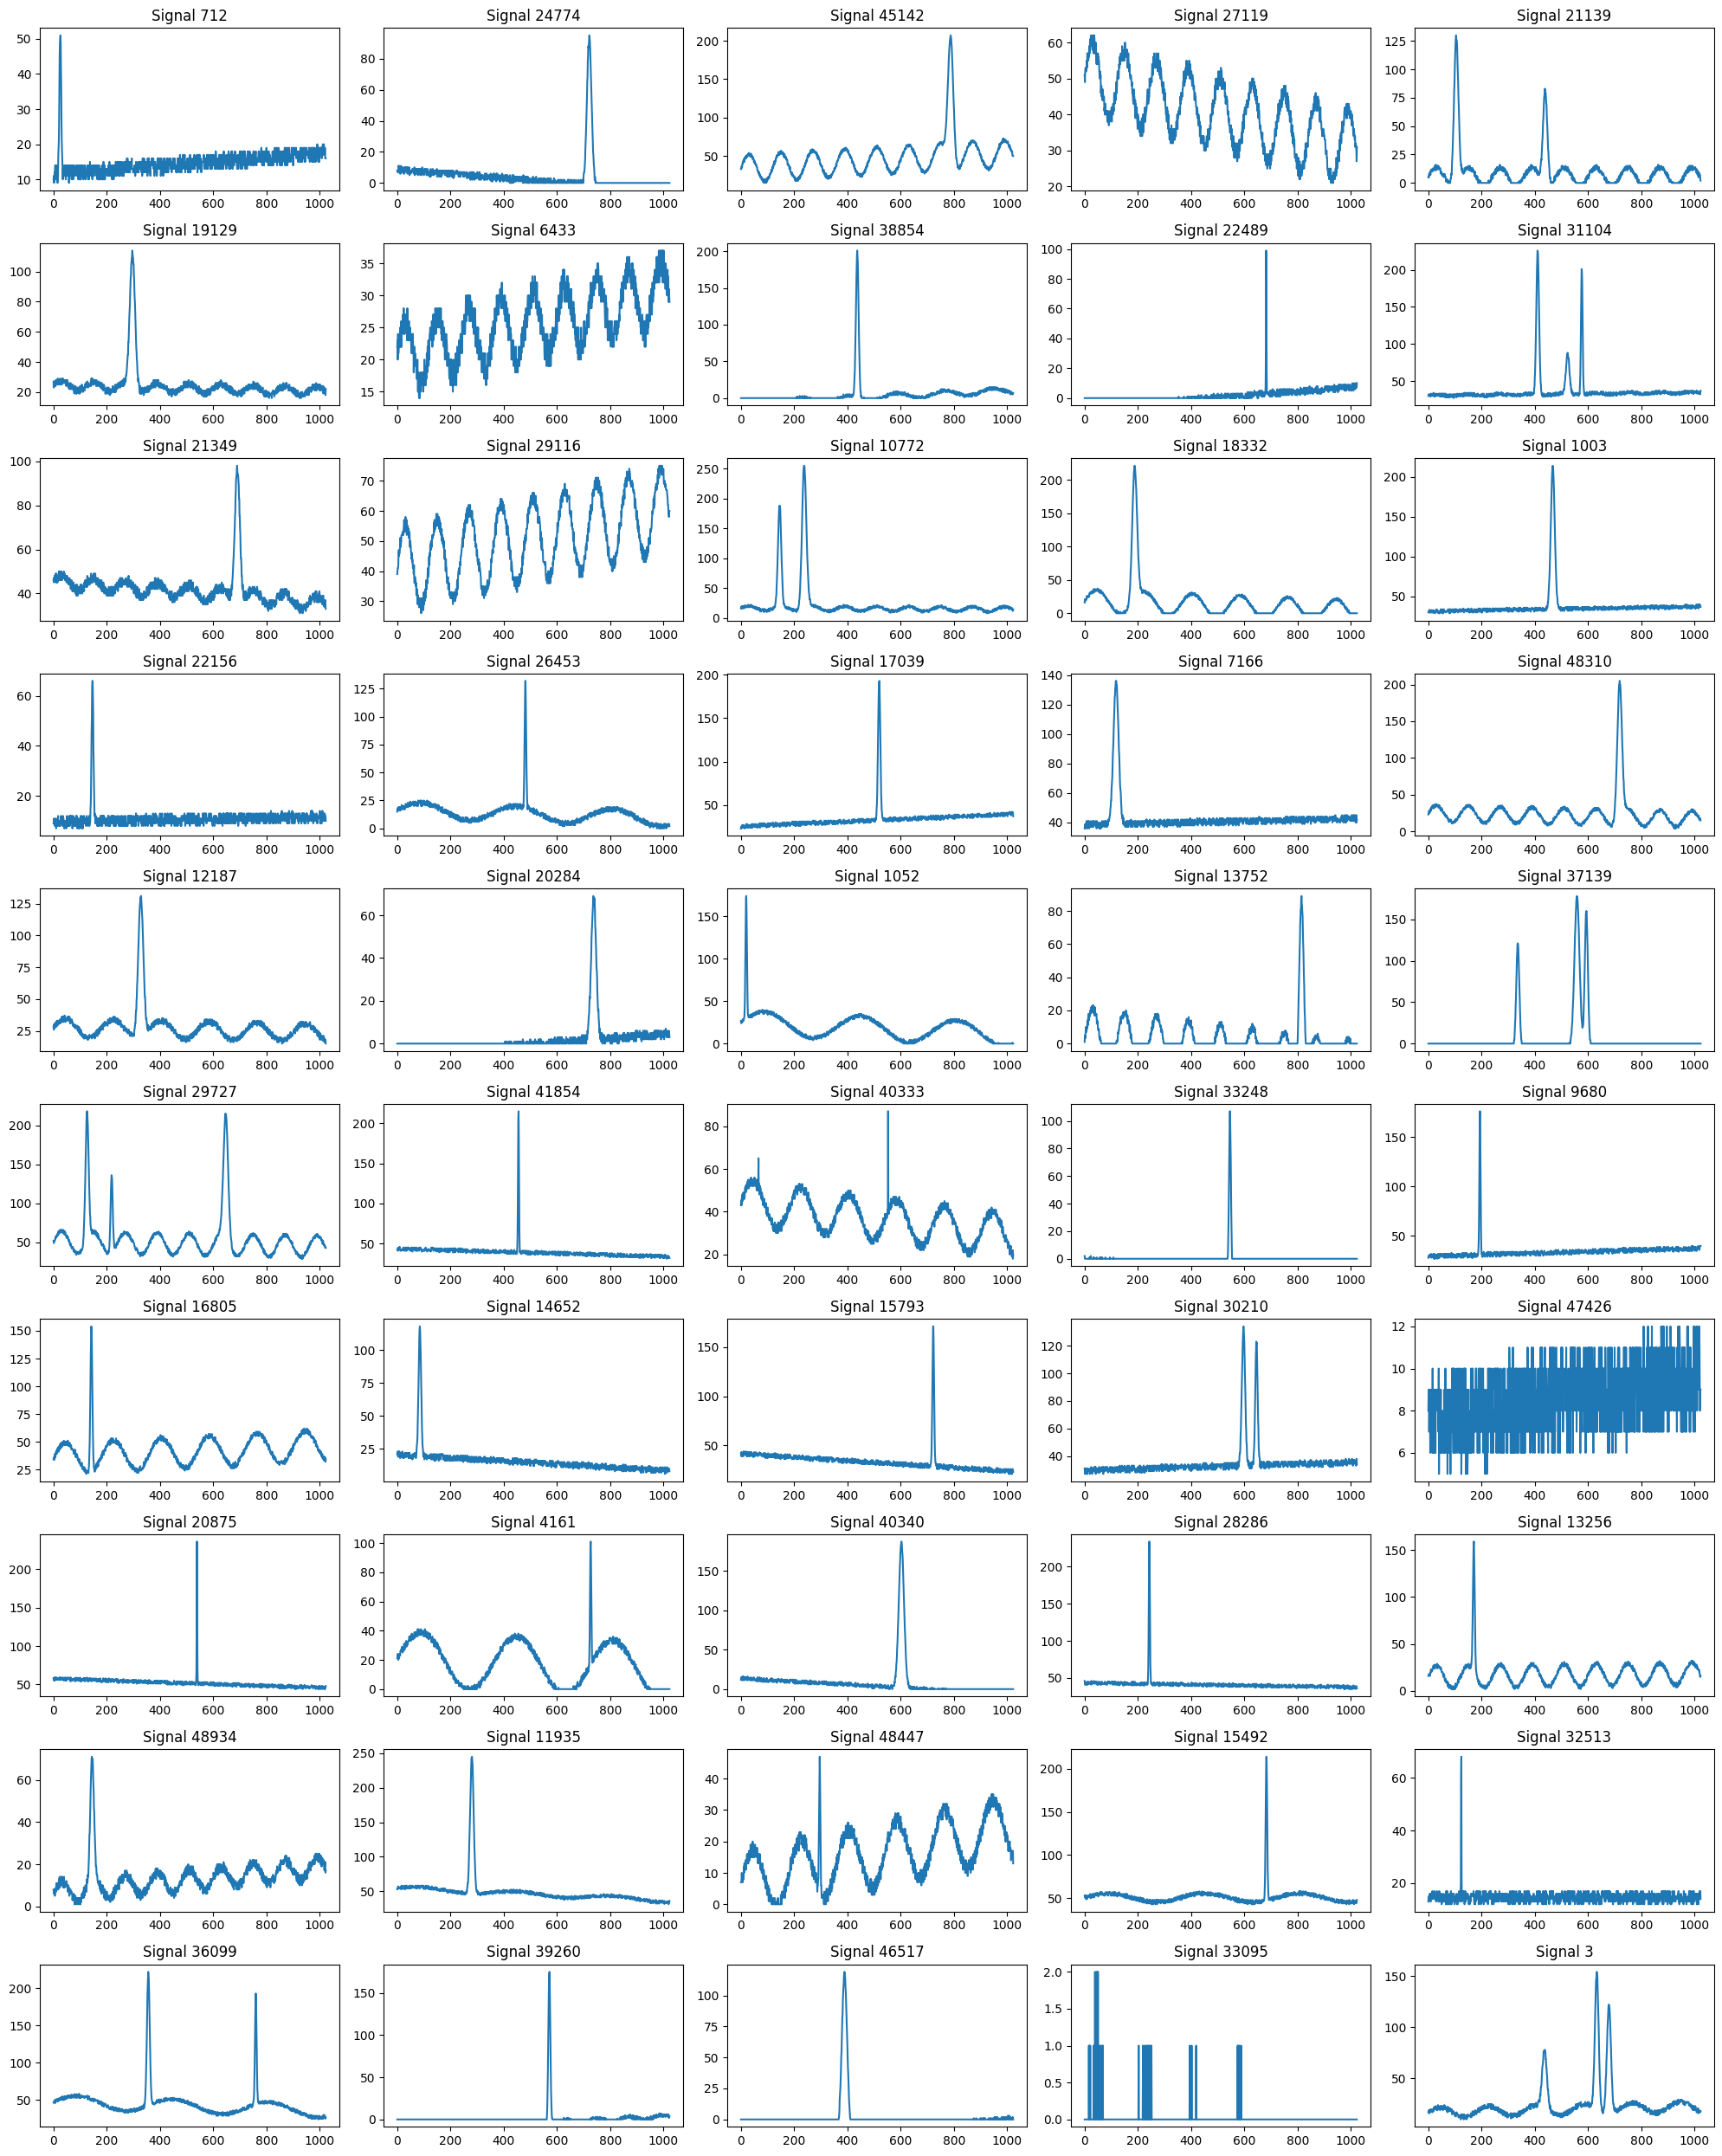

In [222]:
signal_processor.plot_signals()

In [224]:
signal_processor.visualize_info()

shape: (54_944, 12)
┌────────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ signal ┆ length ┆ n_peak ┆ pos_1 ┆ heigh ┆ width ┆ pos_2 ┆ heigh ┆ width ┆ pos_3 ┆ heigh ┆ width │
│ _id    ┆ ---    ┆ s      ┆ ---   ┆ t_1   ┆ _1    ┆ ---   ┆ t_2   ┆ _2    ┆ ---   ┆ t_3   ┆ _3    │
│ ---    ┆ i64    ┆ ---    ┆ f64   ┆ ---   ┆ ---   ┆ f64   ┆ ---   ┆ ---   ┆ f64   ┆ ---   ┆ ---   │
│ i64    ┆        ┆ i64    ┆       ┆ f64   ┆ f64   ┆       ┆ f64   ┆ f64   ┆       ┆ f64   ┆ f64   │
╞════════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ 0      ┆ 610    ┆ 1      ┆ 268.2 ┆ 165.6 ┆ 7.799 ┆ null  ┆ null  ┆ null  ┆ null  ┆ null  ┆ null  │
│        ┆        ┆        ┆ 59369 ┆ 57379 ┆ 758   ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1      ┆ 847    ┆ 2      ┆ 385.5 ┆ 197.1 ┆ 1.325 ┆ 385.5 ┆ 197.1 ┆ 1.325 ┆ null  ┆ null  ┆ null  │
│        ┆        ┆        ┆ 81116 ┆ 77826 ┆ 141   ┆ 81116 ┆ 77826 ┆ 14

## Data Aumentation

In [227]:
signal_processor.visualize_info(augmented=True)

shape: (109_888, 12)
┌────────┬────────┬────────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┬───────┐
│ signal ┆ length ┆ n_peak ┆ pos_1 ┆ heigh ┆ width ┆ pos_2 ┆ heigh ┆ width ┆ pos_3 ┆ heigh ┆ width │
│ _id    ┆ ---    ┆ s      ┆ ---   ┆ t_1   ┆ _1    ┆ ---   ┆ t_2   ┆ _2    ┆ ---   ┆ t_3   ┆ _3    │
│ ---    ┆ i64    ┆ ---    ┆ f64   ┆ ---   ┆ ---   ┆ f64   ┆ ---   ┆ ---   ┆ f64   ┆ ---   ┆ ---   │
│ i64    ┆        ┆ i64    ┆       ┆ f64   ┆ f64   ┆       ┆ f64   ┆ f64   ┆       ┆ f64   ┆ f64   │
╞════════╪════════╪════════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╪═══════╡
│ 0      ┆ 610    ┆ 1      ┆ 268.2 ┆ 165.6 ┆ 7.799 ┆ null  ┆ null  ┆ null  ┆ null  ┆ null  ┆ null  │
│        ┆        ┆        ┆ 59369 ┆ 57379 ┆ 758   ┆       ┆       ┆       ┆       ┆       ┆       │
│ 1      ┆ 847    ┆ 2      ┆ 385.5 ┆ 197.1 ┆ 1.325 ┆ 385.5 ┆ 197.1 ┆ 1.325 ┆ null  ┆ null  ┆ null  │
│        ┆        ┆        ┆ 81116 ┆ 77826 ┆ 141   ┆ 81116 ┆ 77826 ┆ 1

In [ ]:
signal_processor.plot_signals(augmented=True)